In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn import metrics

In [94]:
df = pd.read_csv('SetBueno.csv')

In [95]:
df

,Unnamed: 0,index,date,Encoded Products,Cadereyta total $,Cadereyta ctdad,Coahuila total $,Coahuila ctdad,Durango total $,Durango ctdad,...,Queretaro total $,Queretaro ctdad,Reynosa total $,Reynosa ctdad,San Luis total $,San Luis ctdad,Total libre de impuestos,Ctdad Ordenada,Indefinido total $,Indefinido ctdad
0,0,4,2022-01-02,Producto 11,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,18162.13,3.5,58623.600,10.5,NaN,NaN
1,1,5,2022-01-02,Producto 6,0.00,0.0,0.000,0.0,0.0,0.0,...,23477.44,3.5,0.0,0.0,0.00,0.0,23477.440,3.5,NaN,NaN
2,2,6,2022-01-02,Producto 24,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,31083.500,3.5,NaN,NaN
3,3,7,2022-01-02,Producto 15,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,42846.020,7.0,NaN,NaN
4,4,8,2022-01-02,Producto 9,0.00,0.0,27154.855,3.5,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,27154.855,3.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26459,26459,4317,2023-12-31,Producto 273,0.00,0.0,34740.090,3.5,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,60970.805,7.0,NaN,NaN
26460,26460,4318,2023-12-31,Producto 273,35273.21,3.5,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,35273.210,3.5,NaN,NaN
26461,26461,4319,2023-12-31,Producto 273,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,41274.205,3.5,NaN,NaN
26462,26462,4320,2023-12-31,Producto 273,0.00,0.0,0.000,0.0,0.0,0.0,...,15192.10,3.5,0.0,0.0,0.00,0.0,15192.100,3.5,NaN,NaN


In [96]:
df.columns

Index(['Unnamed: 0', 'index', 'date', 'Encoded Products', 'Cadereyta total $',
       'Cadereyta ctdad', 'Coahuila total $', 'Coahuila ctdad',
       'Durango total $', 'Durango ctdad', 'Expos F total $', 'Expos F ctdad',
       'Laredo total $', 'Laredo ctdad', 'Monterrey total $',
       'Monterrey ctdad', 'Online total $', 'Online ctdad',
       'Queretaro total $', 'Queretaro ctdad', 'Reynosa total $',
       'Reynosa ctdad', 'San Luis total $', 'San Luis ctdad',
       'Total libre de impuestos', 'Ctdad Ordenada', 'Indefinido total $',
       'Indefinido ctdad'],
      dtype='object')

In [97]:
# Lista de ciudades para las que deseas realizar el proceso
ciudades = ['Cadereyta', 'Coahuila', 'Durango', 'Expos F', 'Laredo', 'Monterrey', 'Online',
            'Queretaro', 'Reynosa', 'San Luis']

# Diccionario para mapear los nombres de las columnas antiguas a los nuevos nombres de columnas
nuevos_nombres = {
    'Cadereyta total $': 'total',
    'Cadereyta ctdad': 'ctdad',
    'Coahuila total $': 'total',
    'Coahuila ctdad': 'ctdad',
    'Durango total $': 'total',
    'Durango ctdad': 'ctdad',
    'Expos F total $': 'total',
    'Expos F ctdad': 'ctdad',
    'Laredo total $': 'total',
    'Laredo ctdad': 'ctdad',
    'Monterrey total $': 'total',
    'Monterrey ctdad': 'ctdad',
    'Online total $': 'total',
    'Online ctdad': 'ctdad',
    'Queretaro total $': 'total',
    'Queretaro ctdad': 'ctdad',
    'Reynosa total $': 'total',
    'Reynosa ctdad': 'ctdad',
    'San Luis total $': 'total',
    'San Luis ctdad': 'ctdad',
}

# Crear un diccionario para almacenar los DataFrames modificados para cada ciudad
dfs_por_ciudad = {}

# Iterar sobre cada ciudad y realizar las operaciones necesarias
for ciudad in ciudades:
    # Selecciona las columnas correspondientes a la ciudad actual
    df_ciudad = df[['Encoded Products', 'date', f'{ciudad} total $', f'{ciudad} ctdad']]
    
    # Cambiar el nombre de la columna 'Encoded Products' eliminando 'Producto' y convirtiéndola a entero
    df_ciudad['Encoded Products'] = df['Encoded Products'].str.replace('Producto', '').str.strip()
    df_ciudad['Encoded Products'] = df_ciudad['Encoded Products'].astype(int)
    
    # Agregar una columna 'Ciudad' con el nombre de la ciudad actual para todas las filas
    df_ciudad['Ciudad'] = ciudad
    
    # Cambiar el nombre de las columnas según el diccionario 'nuevos_nombres'
    df_ciudad = df_ciudad.rename(columns=nuevos_nombres)
    
    # Guardar el DataFrame modificado para la ciudad actual en el diccionario 'dfs_por_ciudad'
    dfs_por_ciudad[ciudad] = df_ciudad


C:\Users\jesus\AppData\Local\Temp\ipykernel_21192\3554873387.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ciudad['Encoded Products'] = df['Encoded Products'].str.replace('Producto', '').str.strip()
C:\Users\jesus\AppData\Local\Temp\ipykernel_21192\3554873387.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ciudad['Encoded Products'] = df_ciudad['Encoded Products'].astype(int)
C:\Users\jesus\AppData\Local\Temp\ipykernel_21192\3554873387.py:42: SettingWithCopyWarning: 
A value is trying to b

In [98]:
df_final = pd.concat(dfs_por_ciudad.values(), ignore_index=True)

In [99]:
df_final

,Encoded Products,date,total,ctdad,Ciudad
0,11,2022-01-02,0.0,0.0,Cadereyta
1,6,2022-01-02,0.0,0.0,Cadereyta
2,24,2022-01-02,0.0,0.0,Cadereyta
3,15,2022-01-02,0.0,0.0,Cadereyta
4,9,2022-01-02,0.0,0.0,Cadereyta
...,...,...,...,...,...
264635,273,2023-12-31,0.0,0.0,San Luis
264636,273,2023-12-31,0.0,0.0,San Luis
264637,273,2023-12-31,0.0,0.0,San Luis
264638,273,2023-12-31,0.0,0.0,San Luis


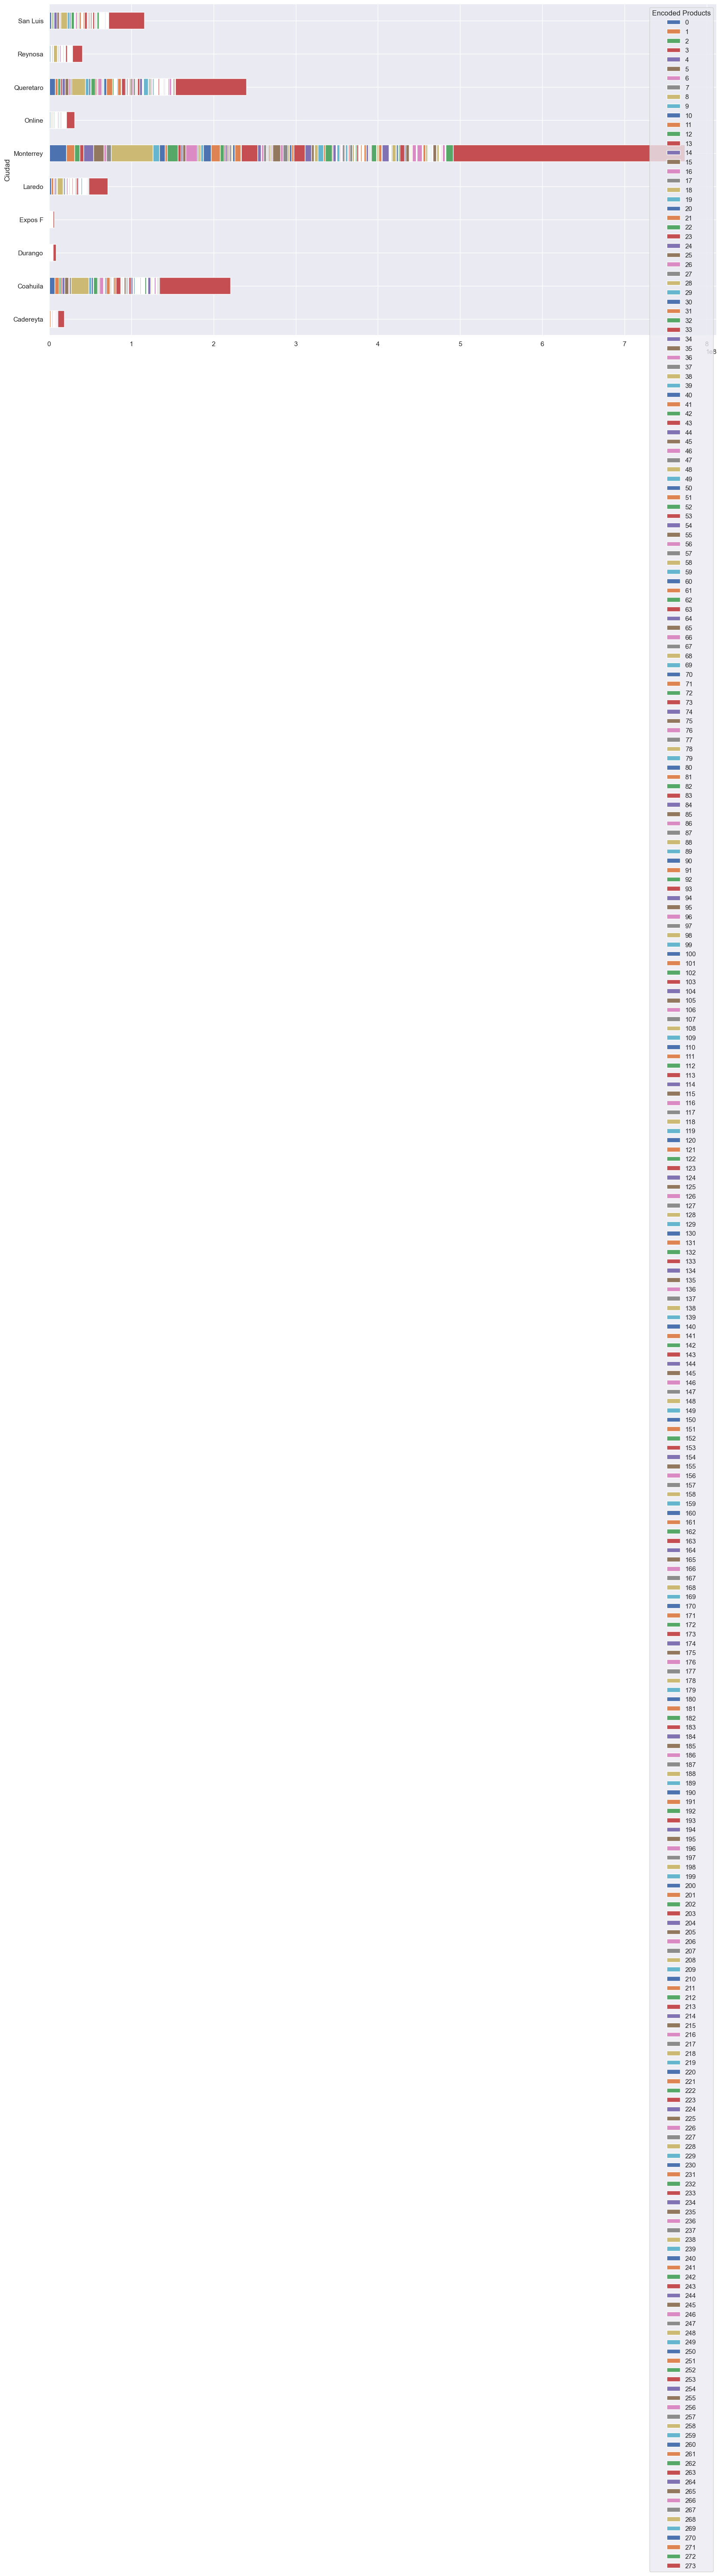

In [100]:
df_final.groupby(['Ciudad','Encoded Products']).sum().unstack().plot(kind='barh',y='total', stacked=True, figsize=(20, 10))
plt.show()

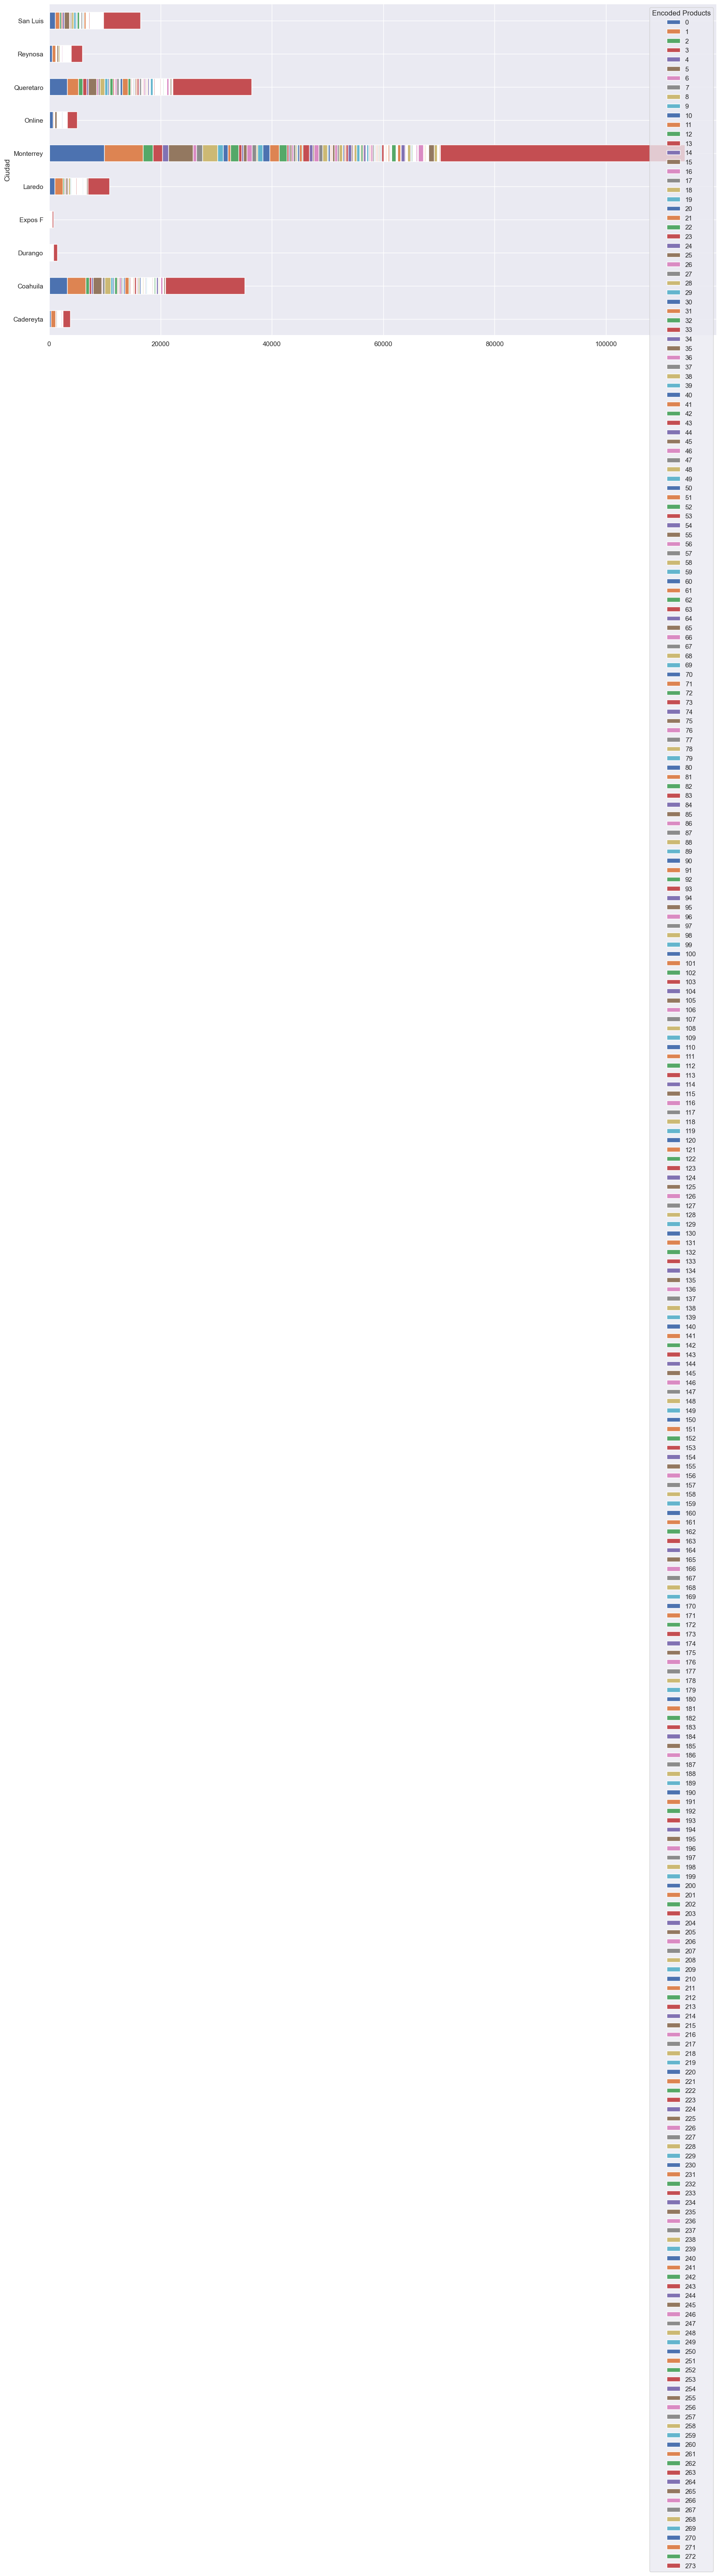

In [101]:
df_final.groupby(['Ciudad','Encoded Products']).sum().unstack().plot(kind='barh',y='ctdad', stacked=True, figsize=(20, 10))
plt.show()

In [102]:
df_final.groupby('Ciudad')['ctdad'].sum().sort_values(ascending=False).head(3)

Ciudad
Monterrey    114184.0
Queretaro     36351.0
Coahuila      35140.0
Name: ctdad, dtype: float64

In [103]:
df_final.groupby('Ciudad')['total'].sum().sort_values(ascending=False).head(3)

Ciudad
Monterrey    7.736584e+08
Queretaro    2.400901e+08
Coahuila     2.206077e+08
Name: total, dtype: float64

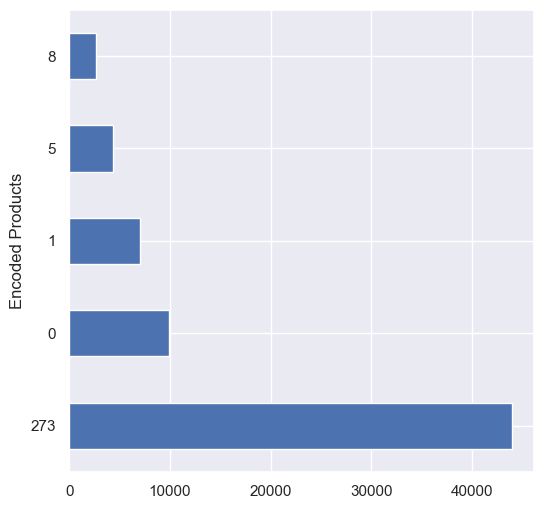

In [104]:
Mty = df_final[df_final['Ciudad'] == 'Monterrey']
# Mty['Encoded Products'] = Mty['Encoded Products'].astype(str)
plt.figure(figsize=(6,6))
Mty.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5).plot(kind='barh')
plt.xticks(rotation=0)
plt.show()

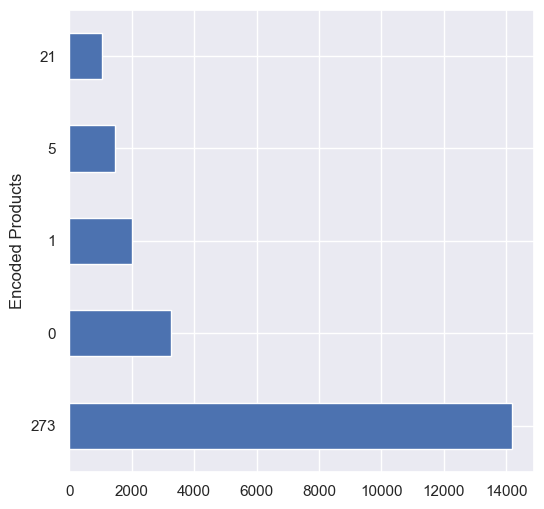

In [106]:
Qro = df_final[df_final['Ciudad'] == 'Queretaro']
# Mty['Encoded Products'] = Mty['Encoded Products'].astype(str)
plt.figure(figsize=(6,6))
Qro.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5).plot(kind='barh')
plt.xticks(rotation=0)
plt.show()

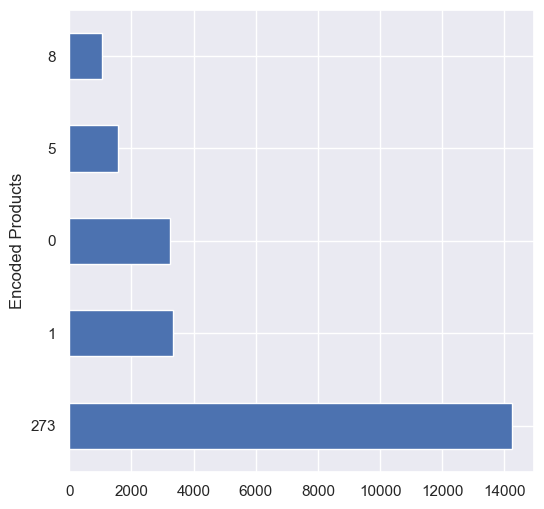

In [107]:
Chl = df_final[df_final['Ciudad'] == 'Coahuila']
# Mty['Encoded Products'] = Mty['Encoded Products'].astype(str)
plt.figure(figsize=(6,6))
Chl.groupby(['Encoded Products'])['ctdad'].sum().sort_values(ascending=False).head(5).plot(kind='barh')
plt.xticks(rotation=0)
plt.show()

In [131]:
df_final['date'] = pd.to_datetime(df_final['date'])
sales_daily = df_final.groupby('date').ctdad.sum()
sales_daily_df = pd.DataFrame(sales_daily)
sales_weekly_mean = sales_daily_df['ctdad'].resample('W').mean()
sales_monthly_mean = sales_daily_df['ctdad'].resample('M').mean()



# Para el weekly

In [132]:
# Suponiendo que tienes un DataFrame llamado df con una columna llamada 'fecha' de tipo datetime
# Aquí están las dos fechas específicas entre las que deseas seleccionar
fecha_inicio = pd.to_datetime('2022-10-03')
fecha_fin = pd.to_datetime('2022-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio) & (sales_weekly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2022-10-09   NaN
2022-10-16   NaN
2022-10-23   NaN
2022-10-30   NaN
2022-11-06   NaN
2022-11-13   NaN
2022-11-20   NaN
2022-11-27   NaN
2022-12-04   NaN
2022-12-11   NaN
2022-12-18   NaN
2022-12-25   NaN
Freq: W-SUN, Name: ctdad, dtype: float64

In [133]:
fecha_inicio = pd.to_datetime('2023-10-03')
fecha_fin = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio) & (sales_weekly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2023-10-08     326.0
2023-10-15     328.0
2023-10-22     331.5
2023-10-29     316.5
2023-11-05     375.0
2023-11-12     333.5
2023-11-19    1317.5
2023-11-26     824.0
2023-12-03     383.0
2023-12-10     362.0
2023-12-17     441.5
2023-12-24     481.0
Freq: W-SUN, Name: ctdad, dtype: float64

In [134]:

fecha_inicio_01 = pd.to_datetime('2022-10-01')
fecha_fin_01 = pd.to_datetime('2022-12-30')
fecha_inicio_02 = pd.to_datetime('2023-10-01')
fecha_fin_02 = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las fechas 1
selection_1 = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio_02) & (sales_weekly_mean.index <= fecha_fin_02)]

# Asignar los valores de 'Ctdad Ordenada' de selection_1 a las fechas correspondientes en product
sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio_01) & (sales_weekly_mean.index <= fecha_fin_01)] = selection_1.values



In [194]:
fecha_inicio = pd.to_datetime('2022-10-03')
fecha_fin = pd.to_datetime('2022-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio) & (sales_weekly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2022-10-09     326.0
2022-10-16     328.0
2022-10-23     331.5
2022-10-30     316.5
2022-11-06     375.0
2022-11-13     333.5
2022-11-20    1317.5
2022-11-27     824.0
2022-12-04     383.0
2022-12-11     362.0
2022-12-18     441.5
2022-12-25     481.0
Freq: W-SUN, Name: ctdad, dtype: float64

In [136]:
fecha_inicio = pd.to_datetime('2023-10-03')
fecha_fin = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_weekly_mean[(sales_weekly_mean.index >= fecha_inicio) & (sales_weekly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2023-10-08     326.0
2023-10-15     328.0
2023-10-22     331.5
2023-10-29     316.5
2023-11-05     375.0
2023-11-12     333.5
2023-11-19    1317.5
2023-11-26     824.0
2023-12-03     383.0
2023-12-10     362.0
2023-12-17     441.5
2023-12-24     481.0
Freq: W-SUN, Name: ctdad, dtype: float64

# Para el monthly

In [137]:
# Suponiendo que tienes un DataFrame llamado df con una columna llamada 'fecha' de tipo datetime
# Aquí están las dos fechas específicas entre las que deseas seleccionar
fecha_inicio = pd.to_datetime('2022-10-03')
fecha_fin = pd.to_datetime('2022-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio) & (sales_monthly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2022-10-31   NaN
2022-11-30   NaN
Freq: M, Name: ctdad, dtype: float64

In [138]:
fecha_inicio = pd.to_datetime('2023-10-03')
fecha_fin = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio) & (sales_monthly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2023-10-31    325.83871
2023-11-30    690.55000
Freq: M, Name: ctdad, dtype: float64

In [139]:

fecha_inicio_01 = pd.to_datetime('2022-10-01')
fecha_fin_01 = pd.to_datetime('2022-12-30')
fecha_inicio_02 = pd.to_datetime('2023-10-01')
fecha_fin_02 = pd.to_datetime('2023-12-30')

# Seleccionar los datos entre las fechas 1
selection_1 = sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio_02) & (sales_monthly_mean.index <= fecha_fin_02)]

# Asignar los valores de 'Ctdad Ordenada' de selection_1 a las fechas correspondientes en product
sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio_01) & (sales_monthly_mean.index <= fecha_fin_01)] = selection_1.values



In [140]:
# Suponiendo que tienes un DataFrame llamado df con una columna llamada 'fecha' de tipo datetime
# Aquí están las dos fechas específicas entre las que deseas seleccionar
fecha_inicio = pd.to_datetime('2022-10-03')
fecha_fin = pd.to_datetime('2022-12-30')

# Seleccionar los datos entre las dos fechas especificadas
datos_entre_fechas = sales_monthly_mean[(sales_monthly_mean.index >= fecha_inicio) & (sales_monthly_mean.index <= fecha_fin)]
datos_entre_fechas

date
2022-10-31    325.83871
2022-11-30    690.55000
Freq: M, Name: ctdad, dtype: float64

# Primer aproach

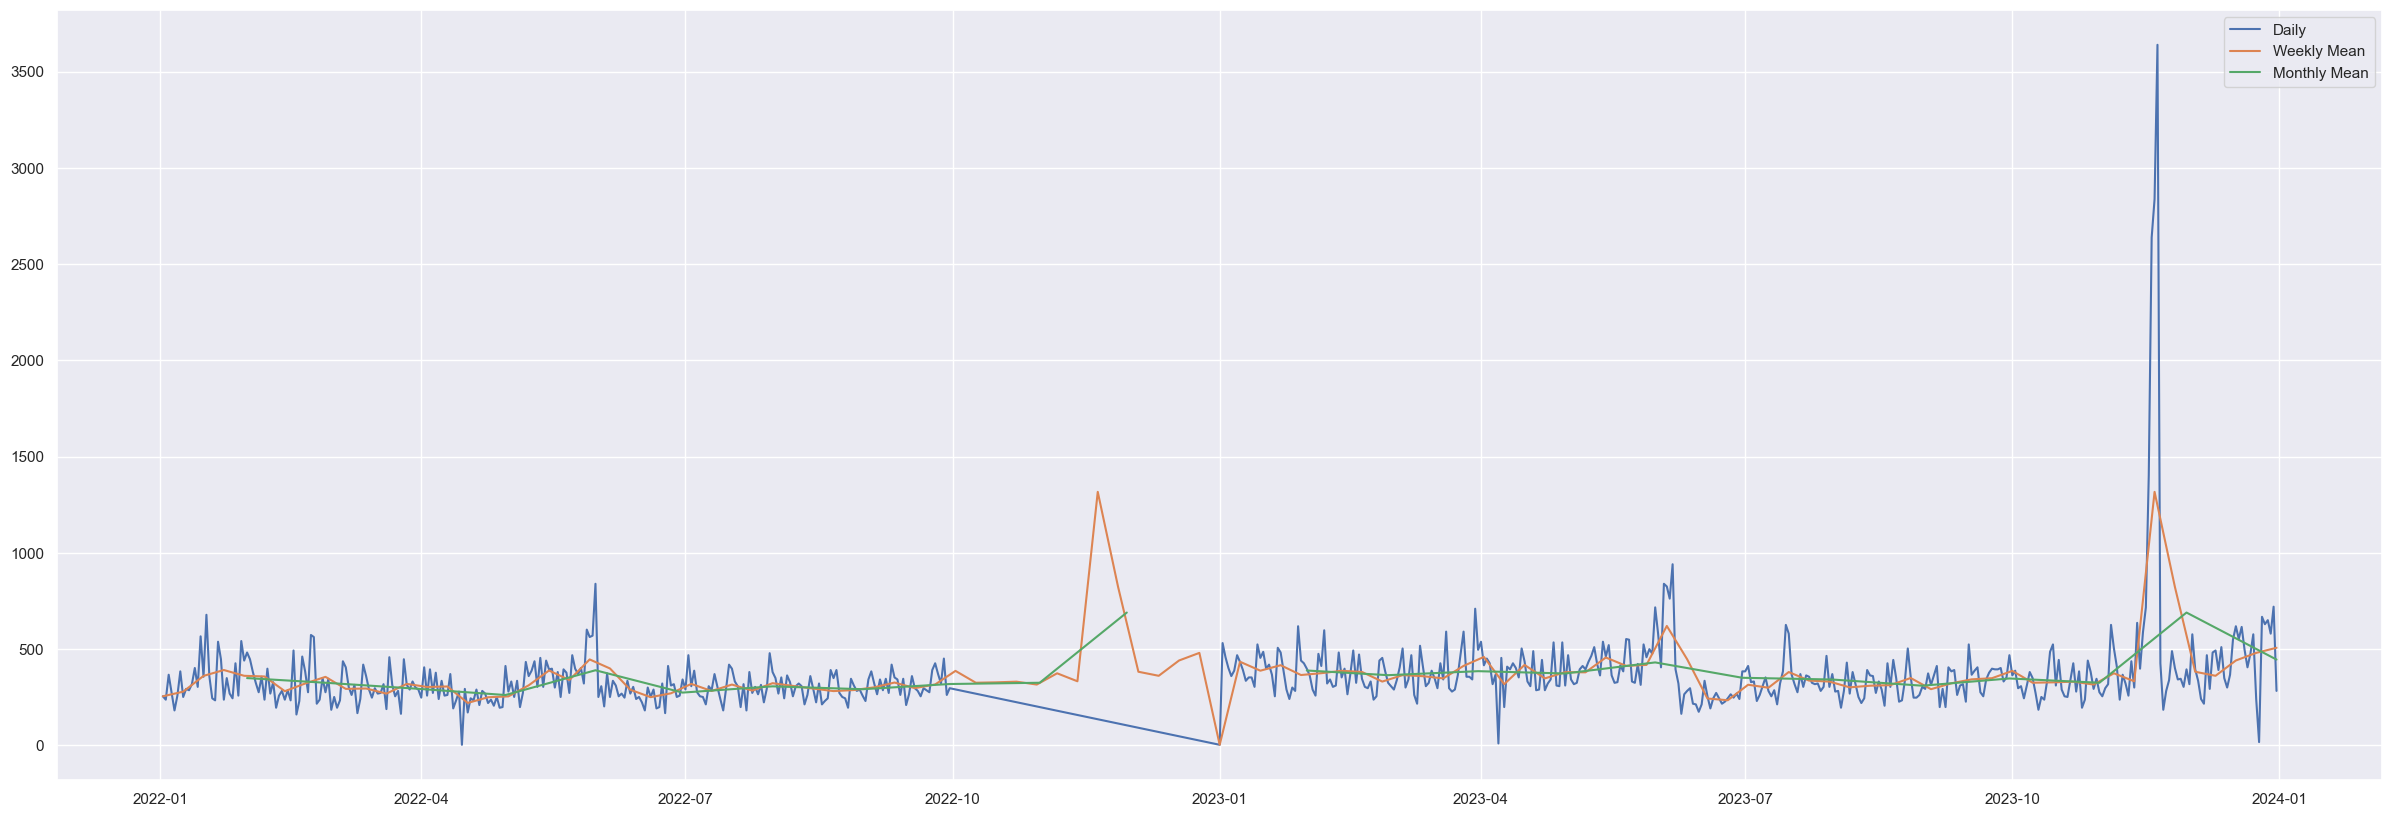

In [141]:
plt.figure(figsize=(30, 10))
plt.plot(sales_daily, label='Daily')
plt.plot(sales_weekly_mean, label='Weekly Mean')
plt.plot(sales_monthly_mean, label='Monthly Mean')
plt.legend()
plt.show()

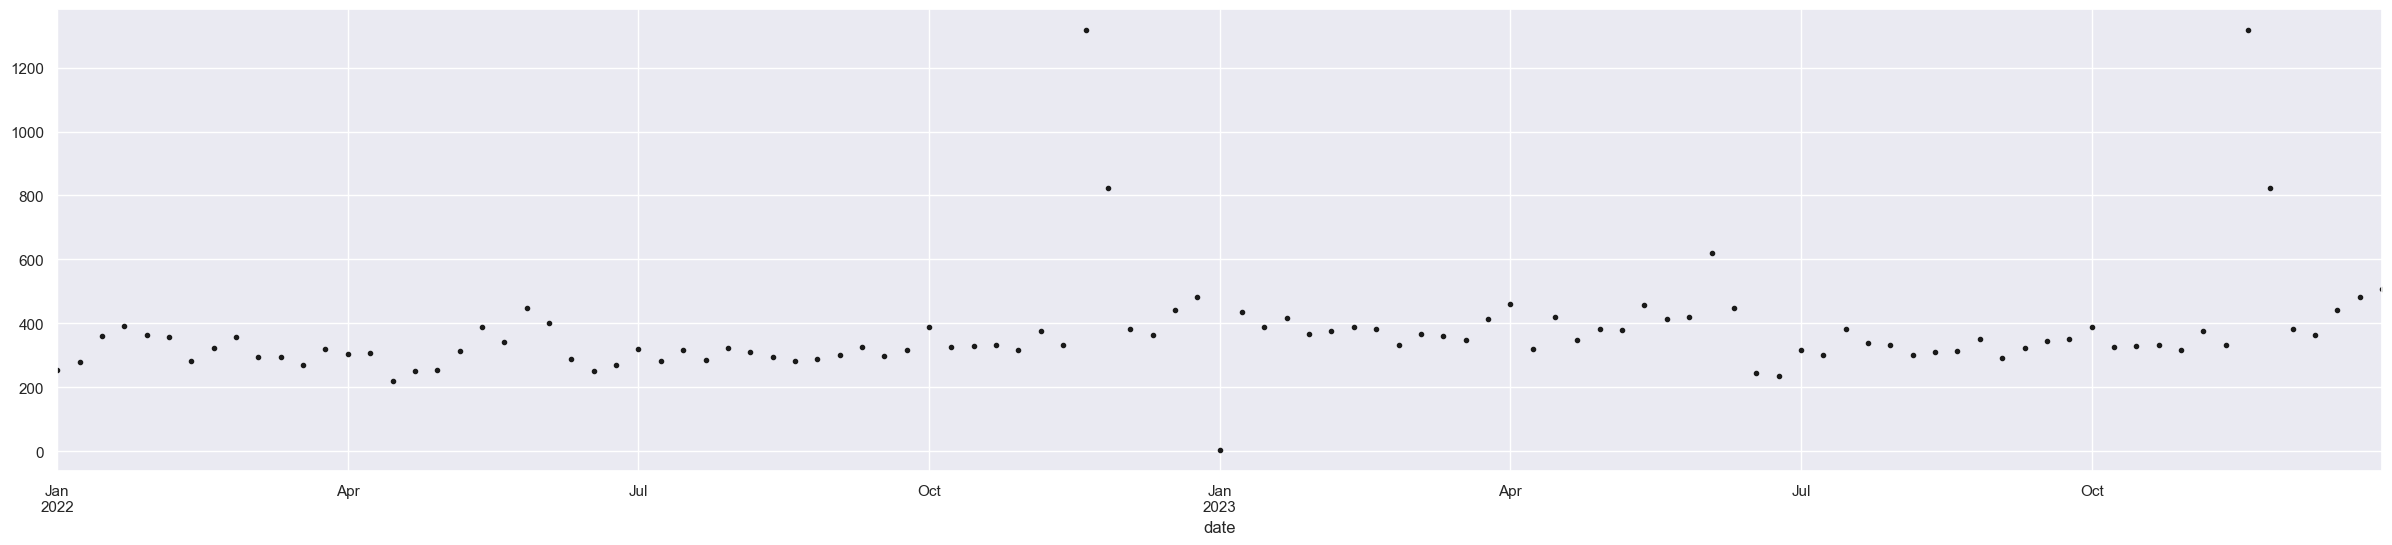

In [125]:
sales_weekly_mean.plot(style='k.', figsize=(30, 6))
plt.show()

In [149]:


sales_monthly = df_final.groupby([df_final['date'].dt.year.rename('year'), df_final['date'].dt.to_period("M").rename('month')])['ctdad'].sum().reset_index()
sales_monthly['month'] = sales_monthly['month'].astype(str)

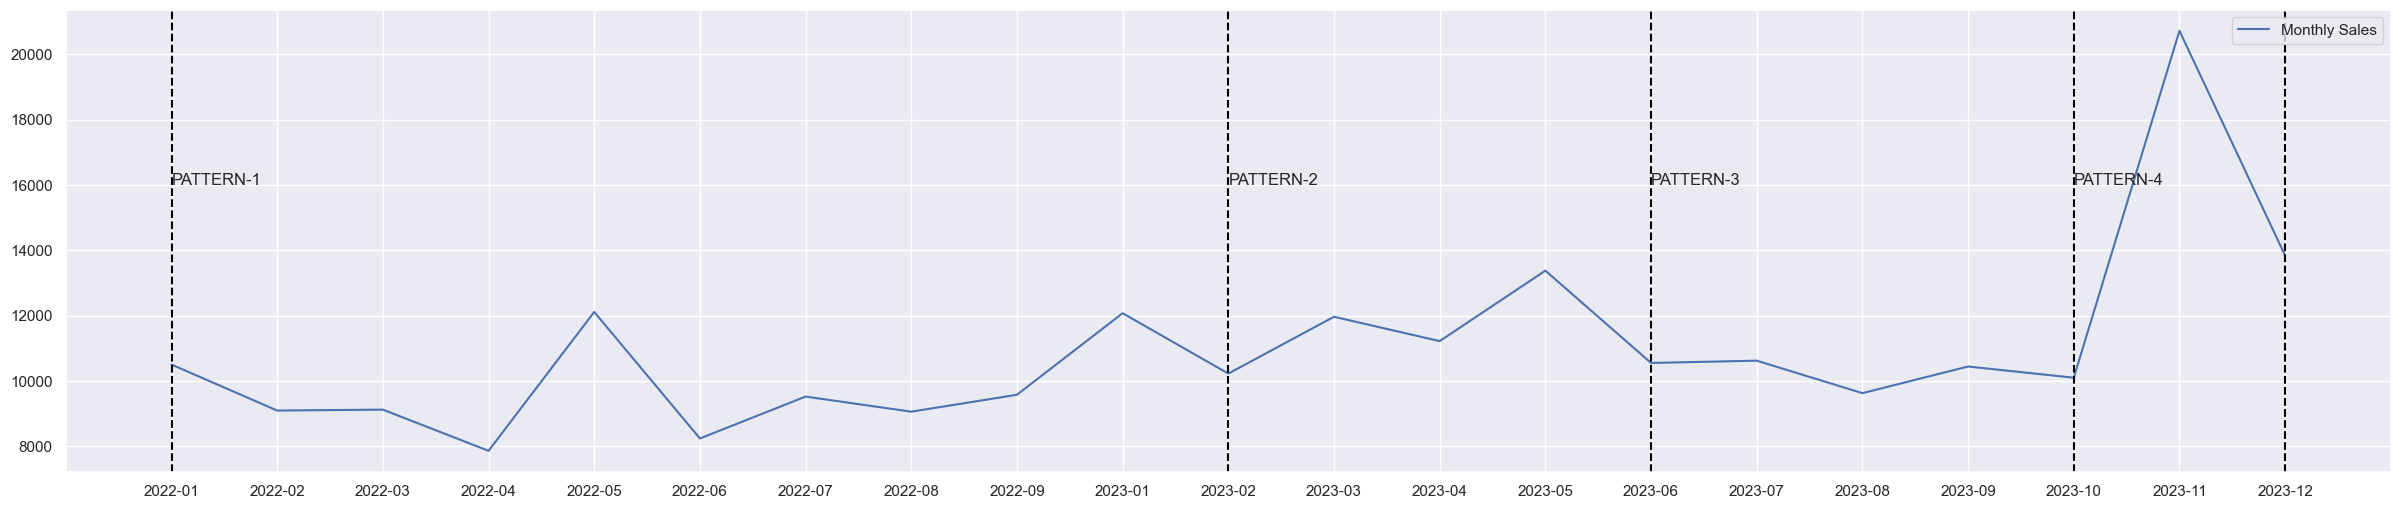

In [156]:
plt.figure(figsize=(30, 6))
plt.plot(sales_monthly['month'],sales_monthly['ctdad'], label='Monthly Sales')
plt.legend()

xcoords = ['2022-01', '2023-02', '2023-06','2023-10', '2023-12']
for xc in xcoords:
    plt.axvline(x=xc, color='black', linestyle='--')
    
plt.annotate('PATTERN-1', ('2022-01', 16000))
plt.annotate('PATTERN-2', ('2023-02', 16000))
plt.annotate('PATTERN-3', ('2023-06', 16000))
plt.annotate('PATTERN-4', ('2023-10', 16000))
plt.annotate('', ('2023-12', 16000))

# plt.annotate('Similiar to PATTERN-1', ('2018-02', 700000))
# plt.annotate('Similiar to PATTERN-2', ('2018-05', 700000))
# plt.annotate('Possible PATTERN-3?', ('2018-08', 750000))

plt.show()

In [160]:
sales_weekly = pd.DataFrame(df_final.groupby([df_final['date'].dt.year.rename('year'), df_final['date'].dt.to_period("W").rename('week')])['ctdad'].sum().reset_index().drop('year', axis=1).set_index('week'))
sales_weekly

,ctdad
week,
2021-12-27/2022-01-02,255.5
2022-01-03/2022-01-09,1956.5
2022-01-10/2022-01-16,2530.5
2022-01-17/2022-01-23,2744.0
2022-01-24/2022-01-30,2534.0
...,...
2023-11-27/2023-12-03,2681.0
2023-12-04/2023-12-10,2534.0
2023-12-11/2023-12-17,3090.5


In [177]:
arima_model=auto_arima(sales_weekly_mean, start_p=1,d=1,start_q=1,
                      max_p=5,max_q=5,max_d=5,m=12,
                        start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,
                      seasonal=True,
                       trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1275.209, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1246.003, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1227.563, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1260.410, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1228.351, Time=0.22 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1228.765, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1231.751, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1244.158, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1239.367, Time=0.19 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=1

In [178]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -610.781
Date:                            Sun, 10 Mar 2024   AIC                           1227.563
Time:                                    21:52:45   BIC                           1235.128
Sample:                                01-02-2022   HQIC                          1230.616
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7854      0.061    -12.825      0.000      -0.905      -0.665
ma.S.L12      -0.8222      0.131     -6.260      0.000      -1.080      -0.565
sigma2      2.954e+04   2042.544     14.460      0.000    2.55e+04    3.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.58   Jarque-Bera (JB):              1119.19
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.63   Skew:                             3.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [180]:
size=int(len(sales_weekly_mean)*0.66)
X_train,X_test=sales_weekly_mean[0:size],sales_weekly_mean[size:len(sales_weekly_mean)]

model=SARIMAX(sales_weekly_mean,
             order=(0,1,1),
             seasonal_order=(0,1,1,12))
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              ctdad   No. Observations:                  105
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -610.781
Date:                            Sun, 10 Mar 2024   AIC                           1227.563
Time:                                    21:53:18   BIC                           1235.128
Sample:                                01-02-2022   HQIC                          1230.616
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7854      0.061    -12.825      0.000      -0.905      -0.665
ma.S.L12      -0.8222      0.131     -6.260      0.000      -1.080      -0.565
sigma2      2.954e+04   2042.544     14.460      0.000    2.55e+04    3.35e+04
===================================================================================
Ljung-Box (L1) (Q):                   5.58   Jarque-Bera (JB):              1119.19
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.63   Skew:                             3.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [187]:
start_index=0
end_index=len(X_train)-1
train_prediction=result.predict(start_index,end_index)

st_index=len(X_train)
ed_index=len(sales_weekly_mean)-1
prediction=result.predict(st_index,ed_index)

<Axes: xlabel='date'>

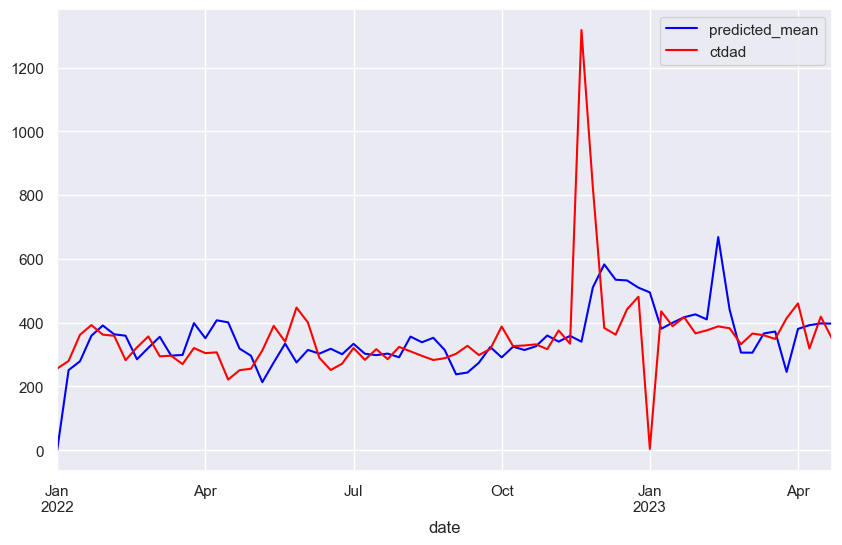

In [188]:
plt.figure(figsize=(10, 6))
train_prediction.plot(legend=True, color='blue')
X_train.plot(legend=True, color = 'red')

In [185]:
print('Absolute Error:', metrics.mean_absolute_error(X_train, train_prediction))
print('MSE:', metrics.mean_squared_error(X_train, train_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_train, train_prediction)))

Absolute Error: 83.16293609376885
MSE: 25485.277083944195
RMSE: 159.641088332372


<Axes: xlabel='date'>

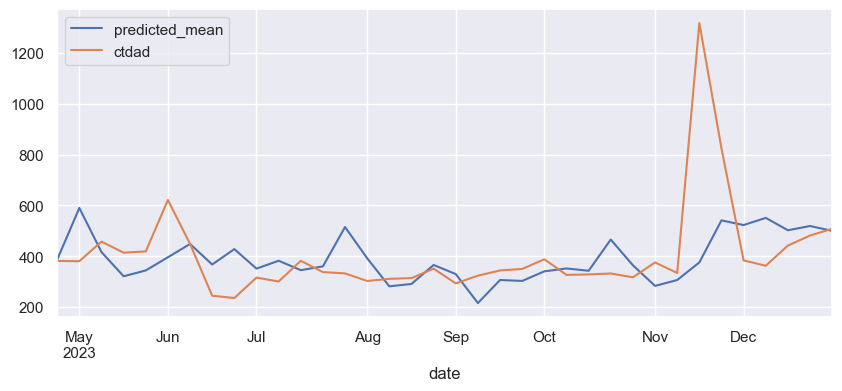

In [189]:
plt.figure(figsize=(10, 4))
prediction.plot(legend=True)
X_test.plot(legend=True)

In [190]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Suponiendo que X_test son los valores verdaderos y prediction son los valores predichos

# Calcula el MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(X_test, prediction)
print('MAPE:', mape)

# Calcula el COD (Coefficient of Determination)
cod = r2_score(X_test, prediction)
print('COD:', cod)
print('Absolute Error:', metrics.mean_absolute_error(X_test, prediction))
print('MSE:', metrics.mean_squared_error(X_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(X_test, prediction)))

MAPE: 23.200219473800544
COD: -0.031230620140064058
Absolute Error: 104.36090466049114
MSE: 35922.078987369314
RMSE: 189.53120847862843


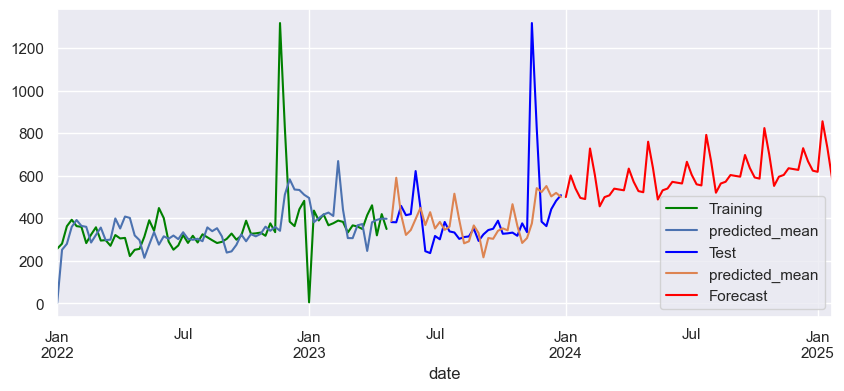

In [192]:
forecast=result.predict(len(sales_weekly_mean), (len(sales_weekly_mean)-1)+56).rename('Forecast')

plt.figure(figsize=(10,4))

X_train.plot(label="Training",color='green')
train_prediction.plot(legend=True)
X_test.plot(label="Test",color='blue')
prediction.plot(legend=True)
forecast.plot(label="Forecast",color="red")
plt.legend(loc="lower right")